In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
import gif

In [2]:
# constants in pc-M_sol-Ma units:
G = 0.004491

# constants in kpc-1e10Msol-Ga units:
#G = 44910

# constants in cgs units:
#G = 6.674e-8
#M_sol = 1.988e33

In [3]:
# vector from p_1 towards p_2:
def distance(p_1, p_2):
    return p_2 - p_1

# absolute of a 3-vector:
def absolute(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

# gravitational acceleration between particles i and j:
def grav_acc(m_j, d_ij, softening = 0):
    #print(G * m_j * d_ij / (absolute(d_ij)**3))
    return G * m_j * d_ij / ((absolute(d_ij) + softening)**3)

In [4]:
# find the acceleration tensor:
def acc_tensor(positions, masses):
    a = np.zeros((3, n, n))
    for i in range(n):
        for j in range(i+1, n):    
            d_ij = distance(positions[:, i], positions[:, j])
            a[:, i, j] = grav_acc(masses[j], d_ij, softening) #acceleration on particle i from particle j
            #a[:, j, i] = grav_acc(masses[i], -d_ij, softening) # on j from i (different masses)
            a[:, j, i] = -a[:, i, j] # on j from i (same masses)
    return a

In [5]:
# find the total acceleration on particle i:   (inefficient!)
def cumulative_acc(positions, masses, i):
    a = np.zeros(3)
    for j in range(0, n):    #acceleration from particle j
        if j == i:
            a = a
        else:
            d_ij = distance(positions[:, i], positions[:, j])
            #print(d_ij)
            a = a + grav_acc(masses[j], d_ij)
    return a

In [16]:
# initial setup of the system (units!):

# all txt files contain (3, n)-arrays where n gives the number of particles
# positions
positions = np.loadtxt('Initial_Setup/initial_positions.txt')
# velocities
velocities = np.loadtxt('Initial_Setup/initial_velocities.txt')

# number of particles
n = np.size(positions, 1)
# number of timesteps
T = 1000
# length of one time step (units!)
t = 0.1
# accelerations
accelerations = np.zeros((3, n))
# masses (plus one heavier mass) (units!)
masses = np.loadtxt('Initial_Setup/masses.txt')
#masses = np.append(masses, 2e8)
#masses = np.ones(n) * 1e-3
# softening parameter (units!)
softening = 1


# Leapfrog Integrator:

# file templates
pos_template = 'Positions/k{i}positions.txt'
vel_template = 'Velocities/k{i}velocities.txt'
acc_template = 'Accelerations/k{i}accelerations.txt'
# 0-step velocities and positions
np.savetxt(vel_template.format(i=0), velocities)
np.savetxt(pos_template.format(i=0), positions)

# 0-step accelerations:
for i in range(n):
    #print(accelerations)
    accelerations[:, i] = cumulative_acc(positions, masses, i)
np.savetxt(acc_template.format(i=0), accelerations)

# outer loop for every time step:
for k in range(1, T):
    # update the position for all particles
    positions += t * velocities + .5 * t**2 * accelerations
    # save the new positions array
    np.savetxt(pos_template.format(i=k), positions)
    
    #remember the last acceleration
    accelerations_prior = accelerations
    
    # acceleration using individual calculations
    #for i in range(n):
    #    accelerations[:, i] = cumulative_acc(positions, masses, i)
    
    # accelerations using acceleration tensor
    a = acc_tensor(positions, masses)
    accelerations = np.sum(a, axis = 2)
    
    # save the new accelerations array
    np.savetxt(acc_template.format(i=k), accelerations)
    
    # update the velocities for all particles
    velocities += .5 * t * (accelerations_prior + accelerations)
    # save the new velocities array
    np.savetxt(vel_template.format(i=k), velocities)

In [5]:
# Plot the Results projected into the x-y-plane
@gif.frame
def plot(i):
    positions = np.loadtxt('Positions/k{i}positions.txt'.format(i=i))
    x_positions = positions[0, :]
    y_positions = positions[1, :]
    z_positions = positions[2, :]
    plt.figure(figsize=(10,10))
    plt.scatter(x_positions, y_positions, 8, z_positions)
    plt.xlim((-30, 30))
    plt.ylim((-30, 30))
    
# stuff we need for plotting
masses = np.loadtxt('Initial_Setup/masses.txt')
T = 1000
n = 1000
t = .1
time = np.linspace(0, T-1, T) * t
    
def radii():
    radiuses = np.zeros((n, T))
    for i in range(T):
        positions = np.loadtxt('Positions/k{i}positions.txt'.format(i=i))
        for j in range(n):
            radiuses[j, i] = absolute(positions[:, j])
    return radiuses

def speeds():
    speed = np.zeros((n, T))
    for i in range(T):
        speed_components = np.loadtxt('Velocities/k{i}velocities.txt'.format(i=i))
        for j in range(n):
            speed[j, i] = absolute(speed_components[:, j])
    return speed

def average(array, T):
    av = np.zeros(T)
    for i in range(T):
        av[i] = np.average(array[:, i])
    return av

# potential energy of particle i at one timestep t
def E_pot_particle_i(positions, masses, i):
    E = 0
    for j in range(i+1, n):
        E = E - G * masses[j] * masses[i] / absolute(distance(positions[:, i], positions[:, j]))
    return E

# potential energy of every particle at every timestep
def E_pot_total():
    E = np.zeros(T)
    for k in range(T):
        positions = np.loadtxt('Positions/k{i}positions.txt'.format(i=k))
        E_k = 0
        for i in range(n):
            for j in range(i+1, n):
                E_k = E_k - G * masses[j] * masses[i] / absolute(distance(positions[:, i], positions[:, j]))
        E[k] = E_k
        print(k)
        print(E[k])
    np.savetxt('Epot.txt', E)
    return E

def E_kin(m, v):
    E = np.zeros((n, T))
    for i in range(T):
        E[:, i] = .5 * m * v[:, i]**2
    np.savetxt('Ekin.txt', E)
    return E

KeyboardInterrupt: 

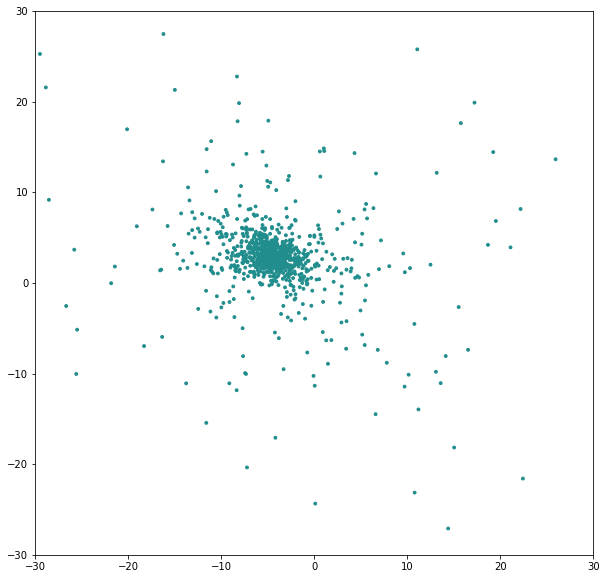

In [7]:
frames = []
for i in range(T):
    frame = plot(i)
    frames.append(frame)
    
gif.save(frames, 'Gifs/n_body_system.gif', duration=60, unit='s', between='startend')

In [8]:
time = np.linspace(0, T-1, T) * t
radiuses = radii()
np.savetxt('radiuses.txt', radiuses)
plt.figure(figsize=(10,10))

#names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])

#label_template = 'Object {i}'
for i in range(n):
    plt.plot(time, radiuses[i, :])
    
plt.title('Distance to the Origin', fontsize=20)
plt.xlabel('time passed /Ma', fontsize=20)
plt.ylabel('D/pc', fontsize=20)
#plt.legend()
plt.grid()
plt.savefig('solarpathlinear.png')

KeyboardInterrupt: 

In [7]:
Ekin = E_kin(masses, speeds())
average_Ekin = average(Ekin, T)

Epot = E_pot_total()
average_Epot = average(Epot, T)

0
-235426638.79644507
1
-228715467.98929015
2
-233939999.67288122
3
-252496644.34102827
4
-268218445.92138952
5
-288939460.35301393
6
-319074585.201225
7
-362537153.9517995
8
-405245821.2770669
9
-437189299.952126
10
-455491812.41289926
11
-471054151.5796022
12
-490420752.15034926
13
-501857130.5149971
14
-507496089.5466999
15
-504580390.48226196
16
-480935923.54399955
17
-440640832.68400294
18
-402385871.2694335
19
-375014824.0437919
20
-353758235.0616154
21
-336463713.7848055
22
-325896866.10788053
23
-317446750.41828793
24
-314567646.665652
25
-313410312.5159621
26
-312800432.23547083
27
-317703607.07963794
28
-323040699.65383697
29
-324910811.76770484
30
-328353468.72254264
31
-329582480.18313074
32
-323387654.72261757
33
-321603143.3294073
34
-327383419.36204636
35
-336898379.6764894
36
-345512244.22445494
37
-355301528.53033805
38
-363183707.03187513
39
-363318499.5536496
40
-359963136.20765823
41
-349136630.6436618
42
-336061860.35288244
43
-324243165.6383446
44
-319598656.24781

356
-335065029.2255987
357
-332910171.1360061
358
-328300185.6265001
359
-327280075.9719198
360
-324922388.4196848
361
-323878479.7550748
362
-324988256.43157005
363
-328381227.02173257
364
-327286889.831492
365
-324933094.31724787
366
-322522344.2676702
367
-322307617.98634547
368
-327228441.1864048
369
-333609990.972805
370
-337844241.81060326
371
-335322136.5643631
372
-333024123.4221634
373
-327824541.13277215
374
-324330650.08745164
375
-324961695.72474355
376
-329694335.35928494
377
-335065099.76673937
378
-335285208.6022952
379
-331955918.81054455
380
-329402249.28423554
381
-327009393.72559637
382
-325048856.1410001
383
-326475702.2207756
384
-327756052.88703656
385
-328122198.18787247
386
-327838144.08238053
387
-329716950.90886194
388
-329400182.4373299
389
-329443598.27857965
390
-328601848.8891936
391
-327285664.09128726
392
-329622667.2494283
393
-331050943.8145841
394
-336051321.69336647
395
-338859715.35119075
396
-337952335.8788377
397
-335882073.96499956
398
-333266896

KeyboardInterrupt: 

In [8]:
Epot = np.loadtxt('Epot.txt')
Ekin = np.loadtxt('Ekin.txt')

totalEkin = np.zeros(T)
for i in range(T):
    totalEkin[i] = np.sum(Ekin[:, i])

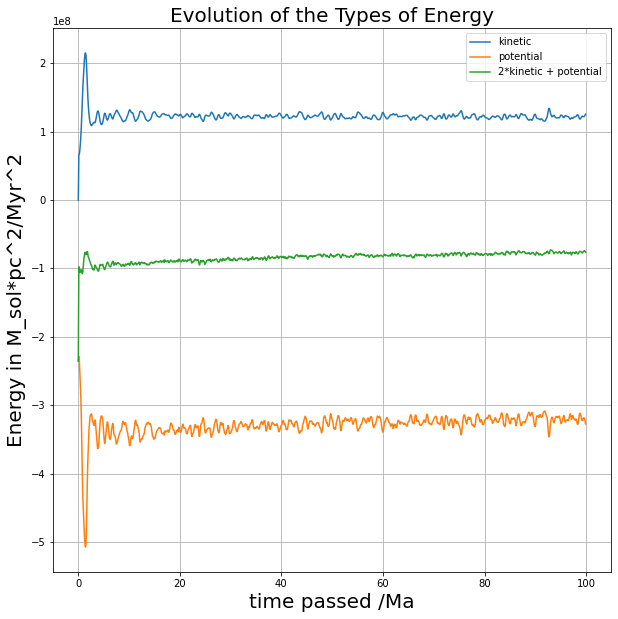

In [18]:
plt.figure(figsize=(10,10))
#label_template = 'Object {i}'
plt.plot(time, totalEkin, label='kinetic')
plt.plot(time, Epot, label='potential')
plt.plot(time, 2*totalEkin + Epot, label='2*kinetic + potential')
    
plt.title('Evolution of the Types of Energy', fontsize=20)
plt.xlabel('time passed /Ma', fontsize=20)
plt.ylabel('Energy in M_sol*pc^2/Myr^2', fontsize=20)
plt.legend()
plt.grid()
plt.savefig('energyevolution.png')